# Clasificacion de perros y gatos

Para esto vamos a hacer uso del data-set de Kaggle el cual se puede encontrar en el siguiente enlace [dogs vs cats] (https://www.kaggle.com/c/dogs-vs-cats/)

## Primer proouesta de modelo.

In [1]:
# load dogs vs cats dataset, reshape and save to a new file
#from os import listdir
import os
# En este caso como se esta usando tensorflow GPU yo tengo que desactivar la revisión de HDF5, para que pueda continuar usandolo con normalidad, este paso puede omitirse si carga la libreria sin error o  se esta usando google colab o tensorflow normal.
os.environ['HDF5_DISABLE_VERSION_CHECK']='2'
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

#things that missing
import random
# define location of dataset

c:\users\laloh\anaconda3\envs\kerasgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
c:\users\laloh\anaconda3\envs\kerasgpu\lib\site-packages\h5py\__init__.py:68: UserWarning: h5py is running against HDF5 1.10.5 when it was built against 1.10.1, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


### Cargar directorios de dataset

Realmente este punto se puede omitir, es unciamente para probar el dataset y como trabajarlo para almacenarlo en numpy, este proceso puede tomar un largo tiempo en terminar la ejecución o aproximadamente 20 min. si se usa tensorflowGPU con una nvidia 1050(o su equivalente) en adelante

In [29]:
#Libreria para desactivar los mensajes de warning.
import warnings
warnings.filterwarnings('ignore')

In [15]:
# define location of dataset
folder = 'train/'
photos, labels = list(), list()

In [3]:
# enumerate files in the directory
for file in listdir(folder):
	# determine class
	output = 0.0
	if file.startswith('cat'):
		output = 1.0
	# load image
	photo = load_img(folder + file, target_size=(200, 200))
	# convert to numpy array
	photo = img_to_array(photo)
	# store
	photos.append(photo)
	labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('dogs_vs_cats_photos.npy', photos)
save('dogs_vs_cats_labels.npy', labels)

(25000, 200, 200, 3) (25000,)


In [1]:
# load and confirm the shape
from numpy import load
photos = load('dogs_vs_cats_photos.npy')
labels = load('dogs_vs_cats_labels.npy')
print(photos.shape, labels.shape)

(25000, 200, 200, 3) (25000,)


In [12]:
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [21]:
import shutil
# seed random number generator
random.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random.random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        shutil.copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        shutil.copyfile(src, dst)

## Modelo base de CNN(Red neuronal convolucional)

In [19]:
# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

### Definir modelo cnn

El siguiente es un modelo simple o al menos no tan complejo, cuenta con una capa convolucional 2d con funcion de activación relu

#### Padding

En nuestra red convolucional usamos un padding = same, en este caso 'same padding' significa que el tamaño de salida de *feature-map* sera la misma entrada de *feature-maps* (suponiendo que, stride=1).  Por ejemplo, si nuestra entrada es nin canales con *feature-maps* de tamaño de 28×28, despues en la salida se espera obtener nout caracteristicas de mapa cada una con tamaño de  28x28 tambien.

#### Input shape

En este caso vamos a redimencionar nuestras imagenes a 200 x 200 pixeles, nuestro *input_shape* ademas va a contener los 3 canales de nuestra imagen (RGB)



In [1]:

#este es el primer modelo, pero se va a cambiar, ya se hicieron pruebas sobre el dando como resultado 72.902 % de presicion
#Ahora se va a comentar



def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



### plots
Vamos a graficar las curvas de aprendizaje haciendo uso de pyplot, de color naranja vamos a graficar la aprte de entrenamiento y de naranja la parte de test, tanto para perdida como para exactitud, para posteriormente guardar el archivo en formato png

In [21]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.savefig('Primer modelo-plot.png')
    pyplot.close()

### class mode

***flow_from_directory()***: Toma el *path* hacia el directorio y genera lotes de datos aumentados.

Si *class_mode* es "*binary*" o "*sparse*" deberia incluir la y_col dada y valores de la clase como strings.
y_col: string o lista, columna/s en el dataframe that que tiene los datos objetivo.

**class_mode**: se puede ocupar una de las siguientes categorias: "binary", "categorical", "input", "multi_output", "raw", sparse" o None. Por defecto: "categorical".

**"binary"**: arreglo 1D de numpy que contiene las etiquetas binarias.

**target_size**: Es las dimensiones a las que vamos a transformar nuestras imagenes.

**batch_size**: Tamaño de los lotes de los datos.


**fit_generator**: Entrena el modelo con los datos generados lote pot lote por un generador de python (o un ejemplo de *Sequence*). El generador se esta ejecutando en paralelo con el modelo, esto es por eficiencia. Por ejemplo, esto te permite hacer en tiempo real el aumento de datos sobre las imagenes en el CPU y en paralelo se entrena el modelo en la GPU.

**ImageDataGenerator**: Genera lotes de tensores con datos de imagenes con datos aumentados en tiempo real. The data will be enroolados (en lotes).

In [22]:
# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    summarize_diagnostics(history)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    #print("the summarize passed")
    #Se supone aqui imprime sus desmadre



## Resultado de la primera prueba

In [7]:
# entry point, run the test harness
run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 67.143


### Segunda ejecución, modificando el modelo.

Al modelo anterior le hemos agregado una capa convolucional más asi como un MaxPooling2D adicional.

In [4]:

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 75.853


### Probando con nuevo modelo

Al igual que en lo anterior, se le agregara al modelo previo una capa de MaxPooling2D y una capa Convulucional 2D

In [20]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
# entry point, run the test harness
run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 79.438


## Mejoras en el modelo de CNN

Se va a iniciar con 3 VGG blocks (i.e. VGG 3) y se explorara algunas mejoras simples para el modelo.

Para evitar el overfitting (sobre entrenamiento) se va a hacer uso de dos tecnicas: 
- dropout regularization 
- data augmentation

Se espera que ambos enfoques disminuyan la tasa de mejora durante el entrenamiento y, con suerte, contrarresten el sobreajuste del conjunto de datos de entrenamiento. Como tal, aumentaremos el número de épocas de entrenamiento de 20 a 50 para dar al modelo más espacio para el refinamiento.

### Dropout Regularization


La regularización de Dropout es una forma computacionalmente barata de regularizar una red neuronal profunda.

El abandono funciona eliminando probabilísticamente, o "abandonando", las entradas a una capa, que pueden ser variables de entrada en la muestra de datos o activaciones de una capa anterior. Tiene el efecto de simular una gran cantidad de redes con estructuras de red muy diferentes y, a su vez, hacer que los nodos en la red sean generalmente más robustos para las entradas.

Para obtener más información sobre la deserción, consulte la publicación:

[How to Reduce Overfitting With Dropout Regularization in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/)

Por lo general, se puede aplicar una pequeña cantidad de abandono después de cada bloque VGG, con más abandono aplicado a las capas completamente conectadas cerca de la capa de salida del modelo.

A continuación se muestra la función define_model () para una versión actualizada del modelo de línea de base con la adición de Dropout. En este caso, se aplica un abandono del 20% después de cada bloque VGG, con una tasa de abandono mayor del 50% después de la capa completamente conectada en la parte del clasificador del modelo.

In [2]:
# baseline model with dropout for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.savefig('Dropout Regularizatio-plot.png')
    pyplot.close()

In [5]:
# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterator
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

In [6]:
# entry point, run the test harness
run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 80.803


<img src="addtionalImages/Dropout Regularizatio-plot.png">

### Prueba con Image Data Augmentation

In [2]:
# modelo abse con data augmentation para el dataset dogs vs cats
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# definir modelo cnn
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compilar modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# grafica de curva de aprendizaje
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # grafica de precision
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # guardar grafica a un archivo
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.savefig('modelo con ImageData-Augmentation-plot.png')
    pyplot.close()

In [5]:
def plotSumm(history):
    history_dict = history.history
    history_dict.keys()
    print(history.history)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    # figure
    pyplot.figure(figsize=(10,5))
    pyplot.subplot(1,2,1)
    pyplot.plot(epochs, loss, 'b', label='Training loss')
    pyplot.plot(epochs, val_loss, 'g', label='Validation loss')
    pyplot.title('Training and validation loss')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.subplot(1,2,2)
    pyplot.plot(epochs, acc, 'r', label='Training accuracy')
    pyplot.plot(epochs, val_acc, 'g', label='Validation accuracy')
    pyplot.title('Training and validation accuracy')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Accuracy')
    pyplot.legend()
    pyplot.show()

In [6]:
# ejecutar la prueba para el modelo
def run_test_harness():
    # define model
    model = define_model()
    # crear generadores de datos
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
        width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # preparar iteradores
    train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # entrenar modelo
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluar modelo
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # curvas de aprendizaje
    summarize_diagnostics(history)
    plotSum(history)
    model.save('data augmentation_model.h5')

In [7]:
# ejecutar la prueba compelta
run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 85.832


NameError: name 'plotSum' is not defined

<img src="addtionalImages/modelo con ImageData-Augmentation-plot.png">

## Modelo con Transfer Learning

In [2]:
# vgg16 modelo usado para "transfer learning" sobre el dataset de dogs and cats
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# definir el modelo cnn
def define_model():
    # cargar el modelo
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # marcar capas cargadas como no entrenables
    for layer in model.layers:
        layer.trainable = False
    # agregar nuevas capas de clasificación
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # definir nuevo modelo
    model = Model(inputs=model.inputs, outputs=output)
    # compilar modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# grafica de diagnostico de curvas de aprendizaje (learning curves)
def summarize_diagnostics(history):
    # grafica de perdida
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # gráfica de precisión
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # Guardar la gráfica en un archivo
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.savefig('modelo final con vgg16-plot.png')
    pyplot.close()

In [5]:
def plotSumm(history):
    history_dict = history.history
    history_dict.keys()
    print(history.history)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    # figure
    pyplot.figure(figsize=(10,5))
    pyplot.subplot(1,2,1)
    pyplot.plot(epochs, loss, 'b', label='Training loss')
    pyplot.plot(epochs, val_loss, 'g', label='Validation loss')
    pyplot.title('Training and validation loss')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.subplot(1,2,2)
    pyplot.plot(epochs, acc, 'r', label='Training accuracy')
    pyplot.plot(epochs, val_acc, 'g', label='Validation accuracy')
    pyplot.title('Training and validation accuracy')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Accuracy')
    pyplot.legend()
    pyplot.show()

In [6]:
# ejecutar la prueba para evaluar el modelo
def run_test_harness():
    # definir modelo
    model = define_model()
    # crear generador de datos
    datagen = ImageDataGenerator(featurewise_center=True)
    # especificar valores medios de imagenet para centrar
    datagen.mean = [123.68, 116.779, 103.939]
    # preparar el iterador
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    # entrenar modelo
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
    # evaluar modelo
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # curvas de aprendizaje
    summarize_diagnostics(history)
    plotSumm(history)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 576s 2s/step - loss: 0.2994 - accuracy: 0.9643 - val_loss: 0.0818 - val_accuracy: 0.9754
Epoch 2/10
293/293 [==============================] - 263s 899ms/step - loss: 0.0250 - accuracy: 0.9914 - val_loss: 0.0369 - val_accuracy: 0.9756
Epoch 3/10
293/293 [==============================] - 264s 901ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0483 - val_accuracy: 0.9776
Epoch 4/10
293/293 [==============================] - 265s 903ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 8.0030e-04 - val_accuracy: 0.9779
Epoch 5/10
293/293 [==============================] - 265s 903ms/step - loss: 6.9251e-04 - accuracy: 0.9999 - val_loss: 2.1552e-04 - val_accuracy: 0.9781
Epoch 6/10
293/293 [==============================] - 265s 903ms/step - loss: 4.5250e-04 - accuracy: 0.9999 - val_loss: 0.0044 - val_accuracy: 0.9781
Epoch 7/10
293/293 [======

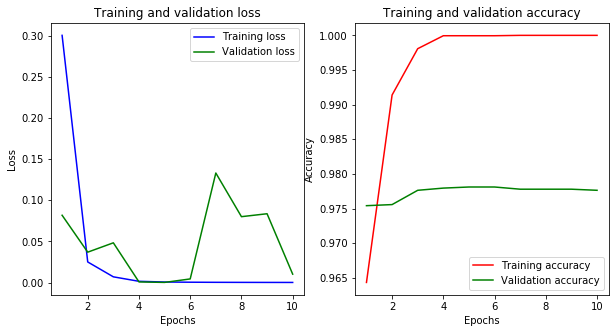

In [7]:
# punto de entrada, ejecutar la prueba
run_test_harness()

<img src="modelo final con vgg16-plot.png">

## Modelo final

Un modelo final generalmente se ajusta a todos los datos disponibles, como la combinación de todos los conjuntos de datos de pruebas y entrenamiento.

Para llevar acabo lo anterior debemos de crear una nueva carpeta para nuestro dataset final. en el cual vamos a tener todas las iamgenes de gatos y perros, pero sin tener la separacion de "train" o de "test", pero para esta prueba vamos a hacer uso unicamente de las imagenes que tenemos labels, que en este caso son las imagenes de entrenamiento.


In [8]:
# organizar el dataset en una estructura util
from os import makedirs
from os import listdir
from shutil import copyfile
# crear directorios
dataset_home = 'finalize_dogs_vs_cats/'
# crear etiquita de subdirectorios
labeldirs = ['dogs/', 'cats/']
for labldir in labeldirs:
    newdir = dataset_home + labldir
    makedirs(newdir, exist_ok=True)
# copiar training data en los diectorios
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    if file.startswith('cat'):
        dst = dataset_home + 'cats/'x|  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + 'dogs/'  + file
        copyfile(src, dst)

In [12]:
# En esta versión de codigo se guarda el modelo para posteriormente seguir procesando
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


In [10]:

# definir un modelo de cnn
def define_model():
    # cargar el modelo (En este caso se estar cargando el modelo existente de vgg16, el cual sera extraido de github)
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # marcar capas cargadas como no entrenables
    for layer in model.layers:
        layer.trainable = False
    # agregar nuevas capas de clasificacion
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # definir nuevo modelo
    model = Model(inputs=model.inputs, outputs=output)
    # compilar modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [11]:

# ejecutar el test para evaluar el modelo
def run_test_harness():
# definir model
    model = define_model()
    # crear generador de datos
    datagen = ImageDataGenerator(featurewise_center=True)
    # especificar valores medios de imagenet para centrar
    datagen.mean = [123.68, 116.779, 103.939]
    # preparar el iterador
    train_it = datagen.flow_from_directory('finalize_dogs_vs_cats/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    # entrenar modelo
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)
    # guardar modelo
    model.save('final_model.h5')



In [12]:
# ejecutar todo el modelo con las pruebas
run_test_harness()

Found 25000 images belonging to 2 classes.


In [2]:
# Hacer una precccion para una nueva imagen
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from keras.preprocessing import image



In [3]:
folder_path = 'predict/'
img_width, img_height = 224, 224
model = load_model('final_model.h5')

In [4]:
# cargar y preparar la iamgen
def load_image(filename):
    # cargar la imagen
    img = load_img(filename, target_size=(224, 224))
    # convertir a arreglo
    img = img_to_array(img)
    # rehacer en forma de una muestra simple con 3 canales
    img = img.reshape(1, 224, 224, 3)
    # centrar los datos de pixel
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img



In [36]:
# cargar la imagen y predecir su clase
def run_example():
    # cargar la iamgen
    img = load_image('predict/negrita.jpg')
    # cargar el modelo
    model = load_model('final_model.h5')
    # predecir su clase
    result = model.predict(img)
    model.summary()
    print()
    print(result[0])



In [6]:
# cargar la imagen y predecir su clase
def run_exampleCat():
    # cargar la iamgen
    img = load_image('predict/gatito de prueba.jpg')
    # cargar el modelo
    model = load_model('final_model.h5')
    # predecir su clase
    result = model.predict(img)
    print(result[0])


In [ ]:
run_exampleCat()

In [9]:
# entry point, run the example
run_example()


[1.]


# Pruebas

In [11]:
import os
os.environ['HDF5_DISABLE_VERSION_CHECK']='2'
from keras.models import load_model
from keras.preprocessing import image
import numpy as np


In [12]:
folder_path = 'predict/'
# path to model
model_path = 'final_model.h5'

In [13]:
img_width, img_height = 224, 224

In [14]:
model = load_model('final_model.h5')

# cargar y preparar la iamgen

In [15]:
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    #img = np.expand_dims(img, axis=0)
    # rehacer en forma de una muestra simple con 3 canales
    img = img.reshape(1, 224, 224, 3)
    # centrar los datos de pixel
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    images.append(img)

In [16]:
# stack up images list to pass for prediction
images = np.vstack(images)

In [17]:
pred = model.predict(images)

In [18]:
print(list(pred))

[array([0.01202452], dtype=float32), array([0.00029418], dtype=float32), array([0.], dtype=float32), array([1.4901161e-07], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32), array([1.], dtype=float32)]


In [19]:
for i in range(0, len(pred)):
    print(pred[i][0])

0.012024522
0.00029417872
0.0
1.4901161e-07
1.0
1.0
1.0
1.0


In [20]:
print(pred[0][0])

0.012024522


In [22]:
print(pred[7][0])

1.0


In [35]:
trDC = [0,0,0,1,1,1,1,1]
print(trDC)

[0, 0, 0, 1, 1, 1, 1, 1]


In [33]:
predictions = np.argmax(pred, 1)
#print("predictions", len(predictions))
#test_labs = np.argmax(test_labels, 1)
#print(len(test_labs))
from pandas import DataFrame
from pandas_ml import ConfusionMatrix
from plotmatrix import pretty_plot_confusion_matrix, PlotMatrix
conf_matrix = ConfusionMatrix(trDC, predictions)

print(conf_matrix)



Predicted  0  1  __all__
Actual                  
0          3  0        3
1          5  0        5
__all__    8  0        8


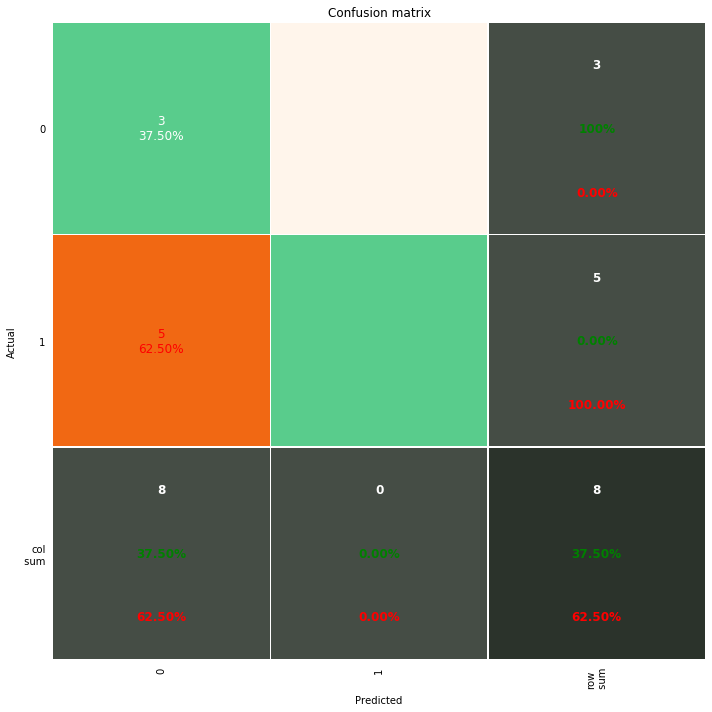

In [34]:
# plot confusion matrix
CM = conf_matrix.to_array()
cf = DataFrame(CM)
pretty_plot_confusion_matrix(cf, annot=True, pred_val_axis='x', figsize=(10,10), fz=12)